# Percolation
This notebook contains code to numerically approximate the percolation threshold of the square, triangular, and honeycomb lattice for both site and bond percolation. The focus of this code is readbility and not execution time.

In [35]:
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

print(sys.getrecursionlimit())
sys.setrecursionlimit(30000)

30000


In [36]:
def is_reachable(graph, visited=None, current_row=None, current_col=None):
    """Marks all nodes reachable from the top row as visited. Works with nodes arranged on a 2d grid.
    graph: matrix of list of tuples. 
    graph[i][j] is a list tuples (row_idx, column_idx) of nodes reachable from node (i, j).
    visited: boolean matrix of visited nodes. If None, start searching from all nodes in top row.
    current_row: current row index.
    current_col: current column index.
    returns: boolean 2d array of visited nodes"""
    L = len(graph)
    L2 = len(graph[0])
    if not visited:
        assert not current_row, "if visited is None, current_row should be None"
        assert not current_col, "if visited is None, current_col should be None"
        visited = [[False for _ in range(L2)] for _ in range(L)]
        for start_idx in range(L):
            visited[0][start_idx] = True
            visited = is_reachable(graph, visited, 0, start_idx)
    else:
        for dr, dc in graph[current_row][current_col]:
            if not visited[dr][dc]:
                visited[dr][dc] = True
                visited = is_reachable(graph, visited, dr, dc)
    return visited

# checks if any of the bottom row nodes are reachable from the top row
is_percolated = lambda graph: any(is_reachable(graph)[-1])

# Square Edge

In [37]:
class SquareGraphEdge():
    """creates a square graph with edges between nodes with probability p_edge."""
    def __init__(self, L:int, p_edge:float):
        self.L = L # side length of graph
        self.p_edge = p_edge
        self.create_graph()
    def create_graph(self):
        # set of neighbors for each node
        # nodes are identified by (row_idx, column_idx)
        self.graph = [[set() for _ in range(self.L)] for _ in range(self.L)]
        # directions where neighbors can be found. edges are undirected.
        directions = [(0,1), (1,0)]
        for row_idx, row in enumerate(self.graph):
            for col_idx, node in enumerate(row):
                for dr, dc in directions:
                    neighbor = (row_idx + dr, col_idx + dc)
                    # if part of graph
                    if neighbor[0] >= 0 and neighbor[0] < self.L and neighbor[1] >= 0 and neighbor[1] < self.L:
                        # add edge in both directions if random number is less than p_edge
                        if random.random() < self.p_edge:
                            node.add(neighbor)
                            self.graph[neighbor[0]][neighbor[1]].add((row_idx, col_idx))

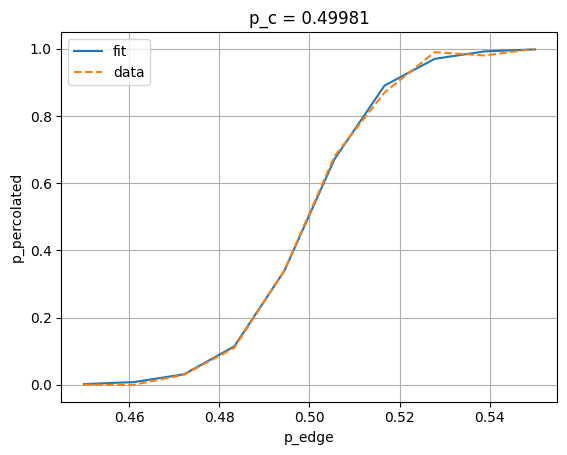

In [38]:
seed = 0
random.seed(seed)

N_samples = 100
L = 100
# p_edges = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ps = np.linspace(0.45, 0.55, 10)
p_percolated = np.zeros_like(ps)

for i, p in enumerate(ps):
    percolated = 0
    for _ in range(N_samples):
        graph = SquareGraphEdge(L=L, p_edge=p)
        percolated += is_percolated(graph.graph)
    p_percolated[i] = percolated/N_samples

def func_to_fit(p, p0, p1):
    return 1./(1. + np.exp(-p0*(p - p1)))

fit_res = curve_fit(func_to_fit, xdata=ps, ydata=p_percolated, p0=(1, 0.5), maxfev=10000)
plt.plot(ps, func_to_fit(ps, *fit_res[0]), label="fit")
plt.plot(ps, p_percolated, label="data", linestyle="--")
plt.title(f"p_c = {fit_res[0][1]:.5f}")
plt.xlabel("p_edge")
plt.ylabel("p_percolated")
plt.legend()
plt.grid()

# Square Bond

In [39]:
class SquareGraphNode():
    def __init__(self, L:int, p_node:float):
        self.L = L
        self.p_node = p_node
        self.create_graph()
    def create_graph(self):
        self.graph = [[set() for _ in range(self.L)] for _ in range(self.L)]
        # 2d array of boolean values indicating if node exists
        self.exist = np.random.choice(a=[True, False], size=(self.L, self.L), p=[self.p_node, 1-self.p_node])
        directions = [(0,1), (1,0)]
        for row_idx, row in enumerate(self.graph):
            for col_idx, node in enumerate(row):
                # only add edges if node exists
                if self.exist[row_idx, col_idx]:
                    for dr, dc in directions:
                        neighbor = (row_idx + dr, col_idx + dc)
                        if neighbor[0] >= 0 and neighbor[0] < self.L and neighbor[1] >= 0 and neighbor[1] < self.L:
                            # only add edge if neighbor exists
                            if self.exist[neighbor[0], neighbor[1]]:
                                node.add(neighbor)
                                self.graph[neighbor[0]][neighbor[1]].add((row_idx, col_idx))

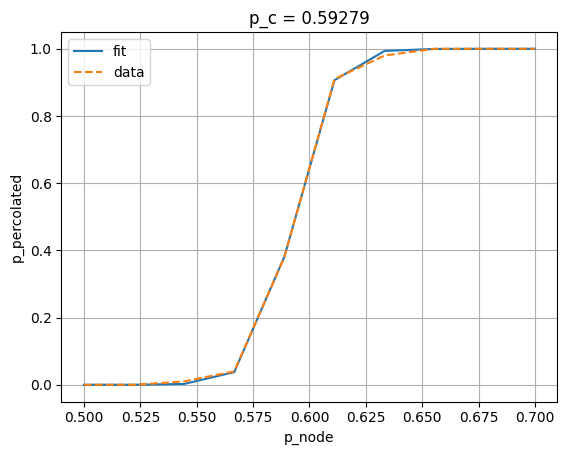

In [40]:
seed = 0
random.seed(seed)
np.random.seed(seed)

N_samples = 100
L = 100
# p_edges = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ps = np.linspace(0.5, 0.7, 10)
p_percolated = np.zeros_like(ps)

for i, p in enumerate(ps):
    percolated = 0
    for _ in range(N_samples):
        graph = SquareGraphNode(L=L, p_node=p)
        percolated += is_percolated(graph.graph)
    p_percolated[i] = percolated/N_samples

def func_to_fit(p, p0, p1):
    return 1./(1. + np.exp(-p0*(p - p1)))

fit_res = curve_fit(func_to_fit, xdata=ps, ydata=p_percolated, p0=(1, 0.5), maxfev=10000)
plt.plot(ps, func_to_fit(ps, *fit_res[0]), label="fit")
plt.plot(ps, p_percolated, label="data", linestyle="--")
plt.title(f"p_c = {fit_res[0][1]:.5f}")
plt.xlabel("p_node")
plt.ylabel("p_percolated")
plt.legend()
plt.grid()

# Triangular Bond

In [41]:
class TriangularGraphEdge():
    def __init__(self, L:int, p_edge:float):
        self.L = L
        self.p_edge = p_edge
        self.create_graph()
    def create_graph(self):
        self.graph = [[set() for _ in range(self.L)] for _ in range(self.L)]
        # different directions depending on row index parity
        directions = [[(0,1), (1,0), (-1, 1)], [(0,1), (1,0), (1, 1)]]
        for row_idx, row in enumerate(self.graph):
            for col_idx, node in enumerate(row):
                for dr, dc in directions[row_idx%2]:
                    neighbor = (row_idx + dr, col_idx + dc)
                    if neighbor[0] >= 0 and neighbor[0] < self.L and neighbor[1] >= 0 and neighbor[1] < self.L:
                        if random.random() < self.p_edge:
                            node.add(neighbor)
                            self.graph[neighbor[0]][neighbor[1]].add((row_idx, col_idx))

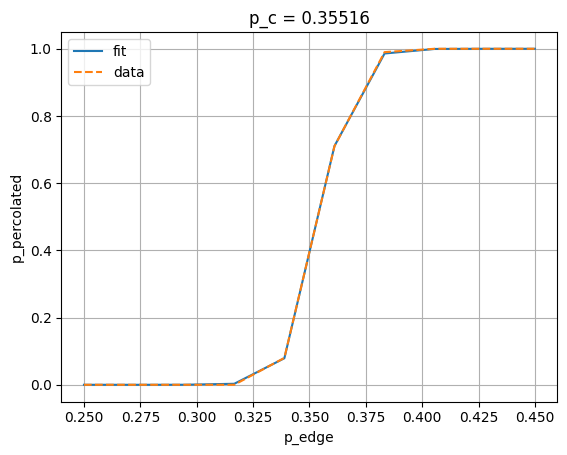

In [42]:
seed = 1
random.seed(seed)

N_samples = 100
L = 100
# p_edges = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ps = np.linspace(0.25, 0.45, 10)
p_percolated = np.zeros_like(ps)

for i, p in enumerate(ps):
    percolated = 0
    for _ in range(N_samples):
        graph = TriangularGraphEdge(L=L, p_edge=p)
        percolated += is_percolated(graph.graph)
    p_percolated[i] = percolated/N_samples

def func_to_fit(p, p0, p1):
    return 1./(1. + np.exp(-p0*(p - p1)))

fit_res = curve_fit(func_to_fit, xdata=ps, ydata=p_percolated, p0=(1, 0.5), maxfev=10000)
plt.plot(ps, func_to_fit(ps, *fit_res[0]), label="fit")
plt.plot(ps, p_percolated, label="data", linestyle="--")
plt.title(f"p_c = {fit_res[0][1]:.5f}")
plt.xlabel("p_edge")
plt.ylabel("p_percolated")
plt.legend()
plt.grid()

# Triangular Site

In [43]:
class TriangularGraphNode():
    def __init__(self, L:int, p_node:float):
        self.L = L
        self.p_node = p_node
        self.create_graph()
    def create_graph(self):
        self.graph = [[set() for _ in range(self.L)] for _ in range(self.L)]
        self.exist = np.random.choices(sequence=[True, False], size=(self.L, self.L), weights=[self.p_node, 1-self.p_node])
        directions = [[(0,1), (1,0), (-1, 1)], [(0,1), (1,0), (1, 1)]]
        for row_idx, row in enumerate(self.graph):
            for col_idx, node in enumerate(row):
                if self.exist[row_idx, col_idx]:
                    for dr, dc in directions[row_idx%2]:
                        neighbor = (row_idx + dr, col_idx + dc)
                        if neighbor[0] >= 0 and neighbor[0] < self.L and neighbor[1] >= 0 and neighbor[1] < self.L:
                            if self.exist[neighbor[0], neighbor[1]]:
                                node.add(neighbor)
                                self.graph[neighbor[0]][neighbor[1]].add((row_idx, col_idx))

In [44]:
seed = 1
random.seed(seed)

N_samples = 100
L = 100
# p_edges = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ps = np.linspace(0.35, 0.75, 10)
p_percolated = np.zeros_like(ps)

for i, p in enumerate(ps):
    percolated = 0
    for _ in range(N_samples):
        graph = TriangularGraphNode(L=L, p_node=p)
        percolated += is_percolated(graph.graph)
    p_percolated[i] = percolated/N_samples

def func_to_fit(p, p0, p1):
    return 1./(1. + np.exp(-p0*(p - p1)))

fit_res = curve_fit(func_to_fit, xdata=ps, ydata=p_percolated, p0=(1, 0.5), maxfev=10000)
plt.plot(ps, func_to_fit(ps, *fit_res[0]), label="fit")
plt.plot(ps, p_percolated, label="data", linestyle="--")
plt.title(f"p_c = {fit_res[0][1]:.5f}")
plt.xlabel("p_edge")
plt.ylabel("p_percolated")
plt.legend()
plt.grid()

AttributeError: module 'numpy.random' has no attribute 'choices'

# Honeycomb site

In [ ]:
class HoneycombGraphEdge():
    def __init__(self, L:int, p_edge:float):
        self.L = L
        self.p_edge = p_edge
        self.create_graph()
    def create_graph(self):
        self.graph = [[set() for _ in range(self.L)] for _ in range(self.L)]
        # different directions depending on row index parity and column index parity
        directions = [[[(0,1)], [(0,1), (1, 0)]], [[(0,1), (1, 0)], [(0,1)]]]
        for row_idx, row in enumerate(self.graph):
            for col_idx, node in enumerate(row):
                for dr, dc in directions[row_idx%2][col_idx%2]:
                    neighbor = (row_idx + dr, col_idx + dc)
                    if neighbor[0] >= 0 and neighbor[0] < self.L and neighbor[1] >= 0 and neighbor[1] < self.L:
                        if random.random() < self.p_edge:
                            node.add(neighbor)
                            self.graph[neighbor[0]][neighbor[1]].add((row_idx, col_idx))

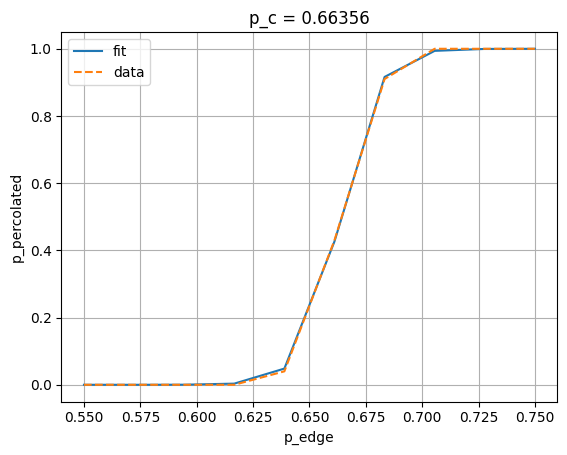

In [ ]:
seed = 1
random.seed(seed)

N_samples = 100
L = 100
# p_edges = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ps = np.linspace(0.55, 0.75, 10)
p_percolated = np.zeros_like(ps)

for i, p in enumerate(ps):
    percolated = 0
    for _ in range(N_samples):
        graph = HoneycombGraphEdge(L=L, p_edge=p)
        percolated += is_percolated(graph.graph)
    p_percolated[i] = percolated/N_samples

def func_to_fit(p, p0, p1):
    return 1./(1. + np.exp(-p0*(p - p1)))

fit_res = curve_fit(func_to_fit, xdata=ps, ydata=p_percolated, p0=(1, 0.5), maxfev=10000)
plt.plot(ps, func_to_fit(ps, *fit_res[0]), label="fit")
plt.plot(ps, p_percolated, label="data", linestyle="--")
plt.title(f"p_c = {fit_res[0][1]:.5f}")
plt.xlabel("p_edge")
plt.ylabel("p_percolated")
plt.legend()
plt.grid()

# Honeycomb site

In [ ]:
class HoneycombGraphNode():
    def __init__(self, L:int, p_node:float):
        self.L = L
        self.p_node = p_node
        self.create_graph()
    def create_graph(self):
        self.graph = [[set() for _ in range(self.L)] for _ in range(self.L)]
        self.exist = np.random.choice(a=[True, False], size=(self.L, self.L), p=[self.p_node, 1-self.p_node])
        directions = [[[(0,1)], [(0,1), (1, 0)]], [[(0,1), (1, 0)], [(0,1)]]]
        for row_idx, row in enumerate(self.graph):
            for col_idx, node in enumerate(row):
                if self.exist[row_idx, col_idx]:
                    for dr, dc in directions[row_idx%2][col_idx%2]:
                        neighbor = (row_idx + dr, col_idx + dc)
                        if neighbor[0] >= 0 and neighbor[0] < self.L and neighbor[1] >= 0 and neighbor[1] < self.L:
                            if self.exist[neighbor[0], neighbor[1]]:
                                node.add(neighbor)
                                self.graph[neighbor[0]][neighbor[1]].add((row_idx, col_idx))

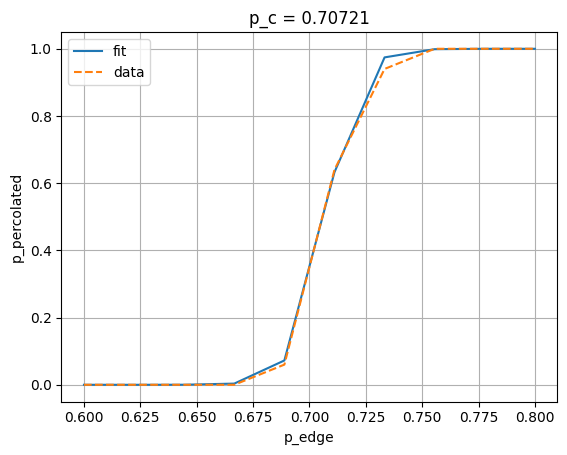

In [ ]:
seed = 1
random.seed(seed)

N_samples = 100
L = 100
# p_edges = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ps = np.linspace(0.6, 0.8, 10)
p_percolated = np.zeros_like(ps)

for i, p in enumerate(ps):
    percolated = 0
    for _ in range(N_samples):
        graph = HoneycombGraphNode(L=L, p_node=p)
        percolated += is_percolated(graph.graph)
    p_percolated[i] = percolated/N_samples

def func_to_fit(p, p0, p1):
    return 1./(1. + np.exp(-p0*(p - p1)))

fit_res = curve_fit(func_to_fit, xdata=ps, ydata=p_percolated, p0=(1, 0.7), maxfev=10000)
plt.plot(ps, func_to_fit(ps, *fit_res[0]), label="fit")
plt.plot(ps, p_percolated, label="data", linestyle="--")
plt.title(f"p_c = {fit_res[0][1]:.5f}")
plt.xlabel("p_edge")
plt.ylabel("p_percolated")
plt.legend()
plt.grid()

# Figure presentation

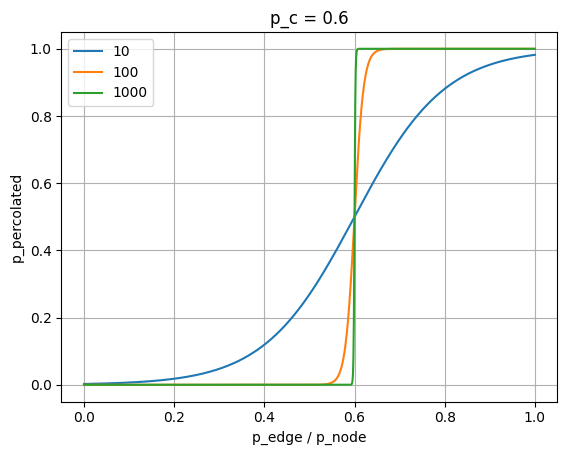

In [ ]:
def func_to_fit(p, p0, p1):
    return 1./(1. + np.exp(-p0*(p - p1)))

perc_thresholds = [0.6] * 4
width = [10, 100, 1000]
labels= [10, 100, 1000]
x_axis = np.linspace(0, 1, int(1e3))

plt.figure()
for width, label, perc_threshold in zip(width, labels, perc_thresholds):
    plt.plot(x_axis, func_to_fit(x_axis, p0=width, p1=perc_threshold), label=label)
plt.xlabel("p_edge / p_node")
plt.ylabel("p_percolated")
plt.title(f"p_c = {perc_thresholds[0]}")
plt.grid()
plt.legend()
plt.savefig("percolation_examples.pdf")